In [1]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/new-york-city-taxi-fare-prediction/sample_submission.csv
/kaggle/input/new-york-city-taxi-fare-prediction/GCP-Coupons-Instructions.rtf
/kaggle/input/new-york-city-taxi-fare-prediction/train.csv
/kaggle/input/new-york-city-taxi-fare-prediction/test.csv


### Setp 1
- Install req libs and Load the datas

In [2]:
import numpy as np
import pandas as pd

In [3]:
data_dir = '/kaggle/input/new-york-city-taxi-fare-prediction/'

In [4]:
!ls -lh {data_dir}

total 5.4G
-rw-r--r-- 1 nobody nogroup  486 Mar 12 04:56 GCP-Coupons-Instructions.rtf
-rw-r--r-- 1 nobody nogroup 336K Mar 12 04:56 sample_submission.csv
-rw-r--r-- 1 nobody nogroup 960K Mar 12 04:56 test.csv
-rw-r--r-- 1 nobody nogroup 5.4G Mar 12 04:56 train.csv


All the data is in the **train.csv** file

In [5]:
# this will take too much tine
# !wc -l {data_dir}/train.csv

In [6]:
!wc -l {data_dir}/test.csv

9914 /kaggle/input/new-york-city-taxi-fare-prediction//test.csv


Getting the first line of the dataset using the _shell_ command

In [7]:
!head {data_dir}/train.csv

In [8]:
!head {data_dir}/test.csv

fare amount is missingw which is the pratical Target column for our analysis

#### Loading
Loading the entire dataset into Pandas is going to be slow, so we can use the following optimizations:

- Ignore the key column
- Parse pickup datetime while loading data
- Specify data types for other columns
    - float32 for geo coordinates
    - float32 for fare amount
    - uint8 for passenger count
- Work with a 1% sample of the data (~500k rows)

In [9]:
# Taking all the columns except the keys
selected_cols = 'fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count'.split(',')
selected_cols

['fare_amount',
 'pickup_datetime',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'passenger_count']

In [10]:
d_types = {
    'fare_amount' : 'float32',
    'pickup_longitude': 'float32',
    'pickup_latitude': 'float32',
    'dropoff_longitude': 'float32',
    'dropoff_latitude' : 'float32',
    'passenger_count' : 'uint8',
}
d_types

{'fare_amount': 'float32',
 'pickup_longitude': 'float32',
 'pickup_latitude': 'float32',
 'dropoff_longitude': 'float32',
 'dropoff_latitude': 'float32',
 'passenger_count': 'uint8'}

In [11]:
import random as rnd
sample_fraction = 0.01
rnd.seed(42)

def skip_row(row_idx) :
#     If this functon retrun false then the number is going to be in data
    if row_idx == 0 :
        return False
    return rnd.random() > sample_fraction

In [12]:
%%time
data = pd.read_csv(data_dir + '/train.csv', 
                   usecols = selected_cols, 
                   dtype = d_types, 
                   parse_dates= ['pickup_datetime'], 
                   skiprows = skip_row) # A function is passed as a prameter

CPU times: user 56.9 s, sys: 5.08 s, total: 1min 1s
Wall time: 2min 2s


In [13]:
data.sample(10)

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
255534,10.3,2009-01-12 17:20:52+00:00,-73.962357,40.779045,-73.964554,40.755711,1
412223,45.0,2011-05-10 00:55:44+00:00,-73.789818,40.646721,-73.989075,40.720520,1
26424,12.9,2009-01-16 16:48:00+00:00,-74.004707,40.711697,-73.975113,40.752010,1
217815,11.3,2012-08-12 18:47:07+00:00,-73.990776,40.745975,-73.950394,40.783581,1
5191,7.5,2013-09-11 09:36:48+00:00,-73.954697,40.783508,-73.960495,40.772987,1
449921,11.0,2015-01-29 11:28:12+00:00,-73.988892,40.748386,-73.966858,40.772430,1
249860,4.9,2011-08-15 05:52:00+00:00,-73.992393,40.734596,-73.988098,40.743328,5
252437,6.0,2012-12-08 18:56:00+00:00,-73.999901,40.718094,-74.006622,40.713715,1
318667,6.0,2014-01-06 23:08:35+00:00,-73.974129,40.751579,-73.989990,40.745026,1
54901,8.1,2009-05-06 08:02:33+00:00,-73.989372,40.752949,-73.987175,40.759850,2


Here I am trying with 1% if the data, We can also try this using _3%, 10%, 50% and even 100%_ of the data

In [14]:
test_data = pd.read_csv(data_dir + '/test.csv', dtype= d_types, parse_dates = ['pickup_datetime'])
test_data.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24+00:00,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24+00:00,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44+00:00,-73.982521,40.751259,-73.979652,40.746140,1
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12+00:00,-73.981163,40.767807,-73.990448,40.751637,1
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12+00:00,-73.966049,40.789776,-73.988564,40.744427,1


In [15]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9914 entries, 0 to 9913
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   key                9914 non-null   object             
 1   pickup_datetime    9914 non-null   datetime64[ns, UTC]
 2   pickup_longitude   9914 non-null   float32            
 3   pickup_latitude    9914 non-null   float32            
 4   dropoff_longitude  9914 non-null   float32            
 5   dropoff_latitude   9914 non-null   float32            
 6   passenger_count    9914 non-null   uint8              
dtypes: datetime64[ns, UTC](1), float32(4), object(1), uint8(1)
memory usage: 319.6+ KB


### Exploring the data

- basic info about training and test set
- EDA and viz
- Ask and Answer the questions

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 552450 entries, 0 to 552449
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   fare_amount        552450 non-null  float32            
 1   pickup_datetime    552450 non-null  datetime64[ns, UTC]
 2   pickup_longitude   552450 non-null  float32            
 3   pickup_latitude    552450 non-null  float32            
 4   dropoff_longitude  552450 non-null  float32            
 5   dropoff_latitude   552450 non-null  float32            
 6   passenger_count    552450 non-null  uint8              
dtypes: datetime64[ns, UTC](1), float32(5), uint8(1)
memory usage: 15.3 MB


In [17]:
data.shape

(552450, 7)

In [18]:
data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,552450.000000,552450.000000,552450.000000,552450.000000,552450.000000,552450.000000
mean,11.354059,-72.497063,39.910500,-72.504326,39.934265,1.684983
std,9.811924,11.618246,8.061114,12.074346,9.255057,1.337664
min,-52.000000,-1183.362793,-3084.490234,-3356.729736,-2073.150635,0.000000
25%,6.000000,-73.992020,40.734875,-73.991425,40.733990,1.000000
50%,8.500000,-73.981819,40.752621,-73.980179,40.753101,1.000000
75%,12.500000,-73.967155,40.767036,-73.963737,40.768059,2.000000
max,499.000000,2420.209473,404.983337,2467.752686,3351.403076,208.000000


In [19]:
data.pickup_datetime.min(), data.pickup_datetime.max()

(Timestamp('2009-01-01 00:11:46+0000', tz='UTC'),
 Timestamp('2015-06-30 23:59:54+0000', tz='UTC'))

In [20]:
test_data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9914 entries, 0 to 9913
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   key                9914 non-null   object             
 1   pickup_datetime    9914 non-null   datetime64[ns, UTC]
 2   pickup_longitude   9914 non-null   float32            
 3   pickup_latitude    9914 non-null   float32            
 4   dropoff_longitude  9914 non-null   float32            
 5   dropoff_latitude   9914 non-null   float32            
 6   passenger_count    9914 non-null   uint8              
dtypes: datetime64[ns, UTC](1), float32(4), object(1), uint8(1)
memory usage: 319.6+ KB


The data is not cleaned as -1000 Latitude does not exist and also _208_ pasengers are can't ride a Taxi

#### Observations
- 550K+ data
- No missing data (in sample)
- Fare ranges from -52 to 499
- Pasengers from 0 to 208
- Seems to be error in the latitue and logitude
- Dates Ranges from 1st Jan 2009 to 30th June 2015

Need to deal with the outliares and preproces the data.

In [21]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9914 entries, 0 to 9913
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   key                9914 non-null   object             
 1   pickup_datetime    9914 non-null   datetime64[ns, UTC]
 2   pickup_longitude   9914 non-null   float32            
 3   pickup_latitude    9914 non-null   float32            
 4   dropoff_longitude  9914 non-null   float32            
 5   dropoff_latitude   9914 non-null   float32            
 6   passenger_count    9914 non-null   uint8              
dtypes: datetime64[ns, UTC](1), float32(4), object(1), uint8(1)
memory usage: 319.6+ KB


In [22]:
test_data.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.974716,40.751041,-73.973656,40.751740,1.671273
std,0.042774,0.033541,0.039072,0.035435,1.278747
min,-74.252190,40.573143,-74.263245,40.568974,1.000000
25%,-73.992500,40.736125,-73.991249,40.735253,1.000000
50%,-73.982327,40.753052,-73.980015,40.754065,1.000000
75%,-73.968012,40.767113,-73.964062,40.768757,2.000000
max,-72.986534,41.709557,-72.990967,41.696682,6.000000


In [23]:
test_data.pickup_datetime.min(), test_data.pickup_datetime.max()

(Timestamp('2009-01-01 11:04:24+0000', tz='UTC'),
 Timestamp('2015-06-30 20:03:50+0000', tz='UTC'))

Training data is Clean we can refer to the taining data for the purpost of clenaing the data.

Like we can remove the columns whose values lies outside the Training data.

## Exploratory Data Analysis

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

Skipping for Now -> Following the content of the Video This will be done a bit later when working properly

In [25]:
data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,552450.000000,552450.000000,552450.000000,552450.000000,552450.000000,552450.000000
mean,11.354059,-72.497063,39.910500,-72.504326,39.934265,1.684983
std,9.811924,11.618246,8.061114,12.074346,9.255057,1.337664
min,-52.000000,-1183.362793,-3084.490234,-3356.729736,-2073.150635,0.000000
25%,6.000000,-73.992020,40.734875,-73.991425,40.733990,1.000000
50%,8.500000,-73.981819,40.752621,-73.980179,40.753101,1.000000
75%,12.500000,-73.967155,40.767036,-73.963737,40.768059,2.000000
max,499.000000,2420.209473,404.983337,2467.752686,3351.403076,208.000000


<Axes: >

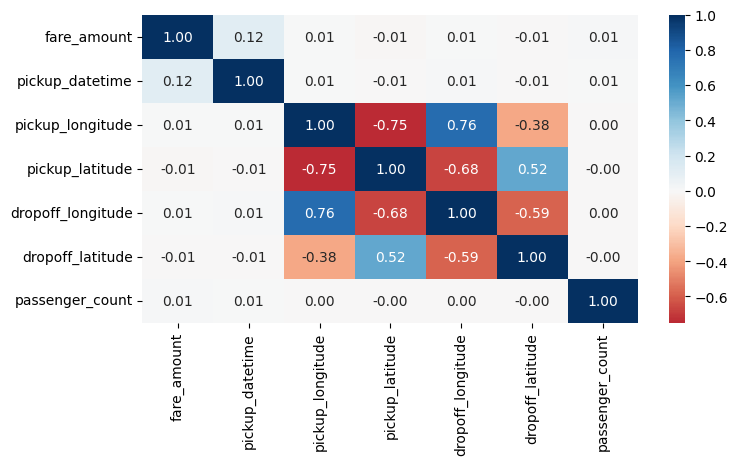

In [26]:
plt.figure(figsize=(8,4))
sns.heatmap(data.corr(), cmap = 'RdBu', annot= True, fmt = '.2f', center = 0)

This is going to be a bad model if we diretly use the columns without fearure Engineering

### Preparing the Dataset for training
- Split it into the training and validation set
- Fill/Remove Missing values
- Extrarct Input and Output
    - Training
    - Validation
    - Test

#### Splitting the dataset

In [27]:
from sklearn.model_selection import train_test_split

In [28]:
train, val = train_test_split(data, test_size = 0.2, random_state = len(data))
len(train), len(val)

(441960, 110490)

In [29]:
train.shape

(441960, 7)

In [30]:
# Dropping the missing values
trian = train.dropna()
val = val.dropna()

train.shape, val.shape

((441960, 7), (110490, 7))

Sepraing the inputs and output cols

In [31]:
train.columns

Index(['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count'],
      dtype='object')

We can't Train a a model on date time column we need to convert the date time to multiple columns by extraicting the values

In [32]:
input_col = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count']
tar_col = 'fare_amount'

In [33]:
x_train = train[input_col].copy()
y_train = train[tar_col].copy()

x_val = val[input_col].copy()
y_val = val[tar_col].copy()

x_train.shape, y_val.shape

((441960, 5), (110490,))

## Hardcoded and baseline Models

Making some of the very simple models which produce very dumb results and compare the models to the This to know the status
and perfoming efficieny of the modle

In [34]:
# Using Classes to make it similar to the SK-learn models

class MeanRegressor:
    def fit(self, inputs, targets):
        self.mean = targets.mean()
        return self
    
    def predict(self, inputs):
        return np.full(inputs.shape[0], self.mean)
    

In [35]:
model = MeanRegressor().fit(x_train, y_train)

In [36]:
model.mean

11.351758

In [37]:
train_pre = model.predict(x_train)

### Evaluating 
using RMSE for the evaluating the error

In [38]:
from sklearn.metrics import mean_squared_error

def rmse(inp, tar):
    return mean_squared_error(inp, tar, squared=False)

In [39]:
train_rmse = rmse(train_pre, y_train)
train_rmse

9.809799

A very high error in predicting the rate

In [40]:
val_rmse = rmse(model.predict(x_val), y_val)
val_rmse

9.820382

### Train and Evaluate Base line Models

In [41]:
from sklearn.linear_model import LinearRegression

In [42]:
model = LinearRegression().fit(x_train, y_train)

In [43]:
train_pre = model.predict(x_train)
train_pre

array([11.27413 , 11.274368, 11.654195, ..., 11.274407, 11.654392,
       11.654364], dtype=float32)

In [44]:
train_rmse = rmse(train_pre, y_train)
train_rmse

9.808442

In [45]:
model.coef_

array([ 0.00041984, -0.00824938,  0.00203213, -0.00225181,  0.09508976],
      dtype=float32)

In [46]:
val_pre = model.predict(x_val)
val_rmse = rmse(val_pre, y_val)
val_rmse

9.819258

Not at all a good model -> almost equal to the hardcoded model

The main reason for this is Taining data have geo-coordinates, which is not in a format useful for the model and we are not using the one of the most imp column : pickup date and time

In [47]:
test_data

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24+00:00,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24+00:00,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44+00:00,-73.982521,40.751259,-73.979652,40.746140,1
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12+00:00,-73.981163,40.767807,-73.990448,40.751637,1
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12+00:00,-73.966049,40.789776,-73.988564,40.744427,1
...,...,...,...,...,...,...,...
9909,2015-05-10 12:37:51.0000002,2015-05-10 12:37:51+00:00,-73.968124,40.796997,-73.955643,40.780388,6
9910,2015-01-12 17:05:51.0000001,2015-01-12 17:05:51+00:00,-73.945511,40.803600,-73.960213,40.776371,6
9911,2015-04-19 20:44:15.0000001,2015-04-19 20:44:15+00:00,-73.991600,40.726608,-73.789742,40.647011,6
9912,2015-01-31 01:05:19.0000005,2015-01-31 01:05:19+00:00,-73.985573,40.735432,-73.939178,40.801731,6


In [48]:
sub_df = pd.read_csv(data_dir + '/sample_submission.csv')
sub_df.head()

,key,fare_amount
0,2015-01-27 13:08:24.0000002,11.35
1,2015-01-27 13:08:24.0000003,11.35
2,2011-10-08 11:53:44.0000002,11.35
3,2012-12-01 21:12:12.0000002,11.35
4,2012-12-01 21:12:12.0000003,11.35


In [49]:
def submission(model, test_data, filename):
    pre_test = model.predict(test_data)
    print(pre_test)
    sub_df.fare_amount = pre_test
    sub_df.to_csv(filename, index = None)
    print(sub_df)

In [50]:
submission(model, test_data[input_col], "LinReg_predection.csv")

[11.274001 11.274337 11.274099 ... 11.750357 11.749635 11.749452]
                              key  fare_amount
0     2015-01-27 13:08:24.0000002    11.274001
1     2015-01-27 13:08:24.0000003    11.274337
2     2011-10-08 11:53:44.0000002    11.274099
3     2012-12-01 21:12:12.0000002    11.273930
4     2012-12-01 21:12:12.0000003    11.273774
...                           ...          ...
9909  2015-05-10 12:37:51.0000002    11.749148
9910  2015-01-12 17:05:51.0000001    11.749104
9911  2015-04-19 20:44:15.0000001    11.750357
9912  2015-01-31 01:05:19.0000005    11.749635
9913  2015-01-18 14:06:23.0000006    11.749452

[9914 rows x 2 columns]


#### Removing the outliares

- fare_amount : 1 to 500
- long : -75 to -72
- lat : 40 to 42
- passenger : 1 to 6

In [51]:
train.columns

Index(['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count'],
      dtype='object')

In [52]:
train.shape, val.shape, test_data.shape

((441960, 7), (110490, 7), (9914, 7))

In [53]:
def remove_out(df):
    return df[(df['fare_amount'] >= 1.) & 
              (df['fare_amount'] <= 500.) &
              (df['pickup_longitude'] >= -75) & 
              (df['pickup_longitude'] <= -72) & 
              (df['dropoff_longitude'] >= -75) & 
              (df['dropoff_longitude'] <= -72) & 
              (df['pickup_latitude'] >= 40) & 
              (df['pickup_latitude'] <= 42) & 
              (df['dropoff_latitude'] >=40) & 
              (df['dropoff_latitude'] <= 42) & 
              (df['passenger_count'] >= 1) & 
              (df['passenger_count'] <= 6)]

In [54]:
train = remove_out(train)
val = remove_out(val)

train.shape, val.shape, test_data.shape

((430990, 7), (107850, 7), (9914, 7))

### Feature Engineering

- Extract parts of date
- Remove outliares
- Add dist b/w Pickup and drop
- Add dist from landmarks

#### Extracting parts form date

In [55]:
def add_date_parts (df, col) :
    df[col + '_year'] = df[col].dt.year
    df[col + '_month'] = df[col].dt.month
    df[col + '_day'] = df[col].dt.day
    df[col + '_weekday'] = df[col].dt.weekday
    df[col + '_hour'] = df[col].dt.hour

In [56]:
input_col

['pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'passenger_count']

In [57]:
train.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
90475,8.100000,2009-11-21 01:29:00+00:00,-73.995415,40.745533,-73.969963,40.759899,1
320476,6.500000,2012-03-31 22:15:00+00:00,-73.996178,40.724167,-73.980553,40.722466,1
189863,23.299999,2009-10-31 22:04:00+00:00,-73.968178,40.786976,-73.996086,40.720158,5
25954,8.900000,2010-04-18 00:28:00+00:00,-73.982391,40.774143,-73.967094,40.806057,1
195808,7.000000,2015-01-08 10:03:13+00:00,-74.008781,40.714054,-73.997429,40.723392,1


In [58]:
add_date_parts(train,'pickup_datetime')
train.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_year,pickup_datetime_month,pickup_datetime_day,pickup_datetime_weekday,pickup_datetime_hour
90475,8.100000,2009-11-21 01:29:00+00:00,-73.995415,40.745533,-73.969963,40.759899,1,2009,11,21,5,1
320476,6.500000,2012-03-31 22:15:00+00:00,-73.996178,40.724167,-73.980553,40.722466,1,2012,3,31,5,22
189863,23.299999,2009-10-31 22:04:00+00:00,-73.968178,40.786976,-73.996086,40.720158,5,2009,10,31,5,22
25954,8.900000,2010-04-18 00:28:00+00:00,-73.982391,40.774143,-73.967094,40.806057,1,2010,4,18,6,0
195808,7.000000,2015-01-08 10:03:13+00:00,-74.008781,40.714054,-73.997429,40.723392,1,2015,1,8,3,10


In [59]:
add_date_parts(val, 'pickup_datetime')
val.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_year,pickup_datetime_month,pickup_datetime_day,pickup_datetime_weekday,pickup_datetime_hour
483027,8.9,2009-09-02 21:14:00+00:00,-73.993179,40.761116,-73.993179,40.761116,1,2009,9,2,2,21
459191,4.9,2009-10-28 18:38:14+00:00,-74.004372,40.742470,-74.004372,40.733536,1,2009,10,28,2,18
310414,8.9,2009-09-29 14:08:36+00:00,-73.981613,40.729198,-73.981606,40.729202,1,2009,9,29,1,14
336771,8.5,2012-08-23 08:57:00+00:00,-73.984741,40.774113,-73.974159,40.757755,1,2012,8,23,3,8
198240,9.5,2013-02-21 09:04:00+00:00,-73.939346,40.804981,-73.962692,40.799610,4,2013,2,21,3,9


In [60]:
add_date_parts(test_data, 'pickup_datetime')
test_data.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_year,pickup_datetime_month,pickup_datetime_day,pickup_datetime_weekday,pickup_datetime_hour
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24+00:00,-73.973320,40.763805,-73.981430,40.743835,1,2015,1,27,1,13
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24+00:00,-73.986862,40.719383,-73.998886,40.739201,1,2015,1,27,1,13
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44+00:00,-73.982521,40.751259,-73.979652,40.746140,1,2011,10,8,5,11
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12+00:00,-73.981163,40.767807,-73.990448,40.751637,1,2012,12,1,5,21
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12+00:00,-73.966049,40.789776,-73.988564,40.744427,1,2012,12,1,5,21


#### Distance b/w pickup and drop locations

We are going to use the [Haversine formula](https://en.wikipedia.org/wiki/Haversine_formula) for the Calculation of the Distance between 2 coordinate in the map

Directly taking the function and copying it online.

In [61]:
import numpy as np

def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    return c
#     km = 6367 * c
#     return km


In [62]:
def add_dist(df) :
    df['distance'] = haversine_np(df.pickup_longitude, df.pickup_latitude, df.dropoff_longitude, df.dropoff_longitude)

In [63]:
add_dist(train)
add_dist(val)
add_dist(test_data)

In [64]:
train.head(5)

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_year,pickup_datetime_month,pickup_datetime_day,pickup_datetime_weekday,pickup_datetime_hour,distance
90475,8.100000,2009-11-21 01:29:00+00:00,-73.995415,40.745533,-73.969963,40.759899,1,2009,11,21,5,1,2.002163
320476,6.500000,2012-03-31 22:15:00+00:00,-73.996178,40.724167,-73.980553,40.722466,1,2012,3,31,5,22,2.001975
189863,23.299999,2009-10-31 22:04:00+00:00,-73.968178,40.786976,-73.996086,40.720158,5,2009,10,31,5,22,2.003342
25954,8.900000,2010-04-18 00:28:00+00:00,-73.982391,40.774143,-73.967094,40.806057,1,2010,4,18,6,0,2.002612
195808,7.000000,2015-01-08 10:03:13+00:00,-74.008781,40.714054,-73.997429,40.723392,1,2015,1,8,3,10,2.002093


#### Distance form popular landmarks

popular land marks : 
- JFK airport
- LGA Airport
- EWR Airport
- Times Square
- Met Meuseum
- WTC
- Statue of Liberty
- Empire state

In [65]:
jfk_longlat = -73.7797, 40.6446
lga_longlat = -73.8718, 40.7733
ewa_longlat = -74.1745, 40.6895

times_longlat = -73.985130, 40.758896
met_longlat = -73.9632, 40.7794
wtc_longlat = -74.013382, 40.712742

liberty_longlat = -74.0445, 40.6892
esb_longlat = -73.9857, 40.7484

In [66]:
def add_landmark_drop_dist(df, landmark, landmark_longlat):
    lon, lat = landmark_longlat
    df[landmark + '_drop_dist'] = haversine_np(lon, lat, df.dropoff_longitude, df.dropoff_latitude)
    
def add_landmark_pick_dist(df, landmark, landmark_longlat):
    lon, lat = landmark_longlat
    df[landmark + '_pick_dist'] = haversine_np(lon, lat, df.dropoff_longitude, df.dropoff_latitude)

In [67]:
def add_landmark(df):
    landmarks = [('jfk', jfk_longlat),
                 ('lga', lga_longlat),
                 ('ewa', ewa_longlat),
                 ('times_square', times_longlat),
                 ('met', met_longlat),
                 ('wtc', wtc_longlat),
                 ('esb', esb_longlat),
                 ('liberty', liberty_longlat)]
    for name, longlat in landmarks:
        add_landmark_drop_dist(df, name, longlat)
        # add_landmark_pick_dist(df, name, longlat)

In [68]:
train.columns

Index(['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count',
       'pickup_datetime_year', 'pickup_datetime_month', 'pickup_datetime_day',
       'pickup_datetime_weekday', 'pickup_datetime_hour', 'distance'],
      dtype='object')

In [69]:
add_landmark(train)
add_landmark(val)
add_landmark(test_data)

In [70]:
train.columns.tolist()

['fare_amount',
 'pickup_datetime',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'passenger_count',
 'pickup_datetime_year',
 'pickup_datetime_month',
 'pickup_datetime_day',
 'pickup_datetime_weekday',
 'pickup_datetime_hour',
 'distance',
 'jfk_drop_dist',
 'lga_drop_dist',
 'ewa_drop_dist',
 'times_square_drop_dist',
 'met_drop_dist',
 'wtc_drop_dist',
 'esb_drop_dist',
 'liberty_drop_dist']

In [71]:
train

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_year,pickup_datetime_month,pickup_datetime_day,...,pickup_datetime_hour,distance,jfk_drop_dist,lga_drop_dist,ewa_drop_dist,times_square_drop_dist,met_drop_dist,wtc_drop_dist,esb_drop_dist,liberty_drop_dist
90475,8.100000,2009-11-21 01:29:00+00:00,-73.995415,40.745533,-73.969963,40.759899,1,2009,11,21,...,1,2.002163,0.003223,0.001319,0.002971,0.000201,0.000352,0.001004,0.000289,0.001579
320476,6.500000,2012-03-31 22:15:00+00:00,-73.996178,40.724167,-73.980553,40.722466,1,2012,3,31,...,22,2.001975,0.002986,0.001690,0.002630,0.000639,0.001020,0.000466,0.000458,0.001026
189863,23.299999,2009-10-31 22:04:00+00:00,-73.968178,40.786976,-73.996086,40.720158,5,2009,10,31,...,22,2.003342,0.003153,0.001887,0.002421,0.000691,0.001122,0.000263,0.000512,0.000838
25954,8.900000,2010-04-18 00:28:00+00:00,-73.982391,40.774143,-73.967094,40.806057,1,2010,4,18,...,0,2.002612,0.003753,0.001383,0.003415,0.000857,0.000468,0.001740,0.001036,0.002282
195808,7.000000,2015-01-08 10:03:13+00:00,-74.008781,40.714054,-73.997429,40.723392,1,2015,1,8,...,10,2.002093,0.003193,0.001876,0.002416,0.000641,0.001077,0.000281,0.000463,0.000863
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
516240,5.000000,2015-05-24 04:40:59+00:00,-73.985359,40.727528,-73.979675,40.739090,1,2015,5,24,...,4,2.002018,0.003118,0.001546,0.002719,0.000353,0.000736,0.000640,0.000181,0.001222
376222,7.700000,2011-04-11 21:10:00+00:00,-73.952942,40.783051,-73.967659,40.800373,5,2011,4,11,...,21,2.002778,0.003684,0.001352,0.003350,0.000760,0.000371,0.001645,0.000938,0.002190
479315,5.700000,2010-10-20 01:44:14+00:00,-73.993790,40.721069,-73.987717,40.710655,1,2010,10,20,...,1,2.002046,0.002985,0.001883,0.002499,0.000843,0.001243,0.000342,0.000659,0.000840
214228,7.500000,2014-09-09 21:35:00+00:00,-73.965958,40.760506,-73.981697,40.743134,5,2014,9,9,...,21,2.002629,0.003178,0.001545,0.002717,0.000279,0.000679,0.000676,0.000106,0.001256


In [72]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
fare_amount,430990.0,11.340783,9.725743,1.000000e+00,6.000000,8.500000,12.500000,499.000000
pickup_longitude,430990.0,-73.975105,0.039283,-7.493459e+01,-73.992210,-73.982094,-73.968369,-72.471581
pickup_latitude,430990.0,40.750999,0.029997,4.006390e+01,40.736546,40.753368,40.767483,41.787712
dropoff_longitude,430990.0,-73.974373,0.038514,-7.494644e+01,-73.991608,-73.980621,-73.965446,-72.113823
dropoff_latitude,430990.0,40.751320,0.033167,4.005421e+01,40.735512,40.753796,40.768387,41.806301
passenger_count,430990.0,1.691944,1.307607,1.000000e+00,1.000000,1.000000,2.000000,6.000000
pickup_datetime_year,430990.0,2011.738405,1.863615,2.009000e+03,2010.000000,2012.000000,2013.000000,2015.000000
pickup_datetime_month,430990.0,6.271097,3.436970,1.000000e+00,3.000000,6.000000,9.000000,12.000000
pickup_datetime_day,430990.0,15.724492,8.691109,1.000000e+00,8.000000,16.000000,23.000000,31.000000
pickup_datetime_weekday,430990.0,3.037210,1.951696,0.000000e+00,1.000000,3.000000,5.000000,6.000000


In [73]:
test_data.describe().T

,count,mean,std,min,25%,50%,75%,max
pickup_longitude,9914.0,-73.974716,0.042774,-74.252190,-73.992500,-73.982327,-73.968012,-72.986534
pickup_latitude,9914.0,40.751041,0.033541,40.573143,40.736125,40.753052,40.767113,41.709557
dropoff_longitude,9914.0,-73.973656,0.039072,-74.263245,-73.991249,-73.980015,-73.964062,-72.990967
dropoff_latitude,9914.0,40.751740,0.035435,40.568974,40.735253,40.754065,40.768757,41.696682
passenger_count,9914.0,1.671273,1.278747,1.000000,1.000000,1.000000,2.000000,6.000000
pickup_datetime_year,9914.0,2011.815816,1.803347,2009.000000,2010.000000,2012.000000,2014.000000,2015.000000
pickup_datetime_month,9914.0,6.857979,3.353272,1.000000,4.000000,7.000000,10.000000,12.000000
pickup_datetime_day,9914.0,16.194170,8.838482,1.000000,9.000000,16.000000,25.000000,31.000000
pickup_datetime_weekday,9914.0,2.852834,1.994451,0.000000,1.000000,3.000000,5.000000,6.000000
pickup_datetime_hour,9914.0,13.467420,6.868584,0.000000,8.000000,15.000000,19.000000,23.000000
